In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import GradScaler, autocast
import tensorflow as tf
from   tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight

import nlpaug.augmenter.word as naw
import random
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

sns.set(rc={'figure.figsize':(20,10)})

/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-11 23:10:49.607962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 23:10:50.265346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load train and test data
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")

print(train_data.head())

# Split train and test data into features and targets
train_features = train_data["lyrics"]
train_targets = train_data["most_common_genre"]

test_features = test_data["lyrics"]
test_targets = test_data["most_common_genre"]

def model_summary(model):
    print("Model summary:")
    print("---------------------------")
    total_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
    print(f"Total parameters: {total_params}")

                       id                                             lyrics  \
0  1FAmKoufyAXMfzPPs9bsjA  i tied my bandana took my pack from the floor ...   
1  3QvPEv8XjHa73iYhaienWw  i want to live on the moon never see a human a...   
2  5VPFATm85G3P04Q5g8yxqr  bitch you know you can t parallel park anyway ...   
3  7J2jCftItt7htcOUdcMnpt  graceless falling slipping in the cold with no...   
4  4cBPzVIbDIQx0LIyauFAy0  madame morse estate stood five hundred years p...   

       artist_name most_common_genre  \
0  Waylon Jennings           country   
1   Phantom Planet              rock   
2    Isaiah Rashad           hip-hop   
3     Matt Pond PA             indie   
4       Ariel Pink               pop   

                                          genre_list  
0  ['country', 'country', 'rock', 'outlaw', 'coun...  
1                                    ['pop', 'rock']  
2  ['hip-hop', 'rap', 'tennessee', 'hip-hop', 'un...  
3                                ['philly', 'indie']  
4  

In [3]:
categories = sorted(list(train_targets.unique()))

# Help of pre-trained embeddings

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LyricsDataset(Dataset):
    def __init__(self, data, labels, augment=False, augmentation_rate=0.1):
        self.data = data
        self.labels = labels
        self.augment = augment
        self.augmentation_rate = augmentation_rate
        self.category_to_index = {category: index for index, category in enumerate(categories)}
        
        self.augmenter = naw.SynonymAug(aug_src='wordnet')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        lyrics = self.data.iloc[index]
        label = self.labels.iloc[index]
        label_index = torch.tensor(self.category_to_index[label], dtype=torch.long).to(device)

        if self.augment:
            lyrics = self.augmenter.augment(lyrics)
            
        return lyrics, label_index
    
class LyricsTextClassificationModel(torch.nn.Module):
    def __init__(self, embedding_model, embedding_dim, categories, model_type = "embedding_then_one_layer", bert_type = "lyricsbert"):
        super(LyricsTextClassificationModel, self).__init__()
        self.embedding_model = embedding_model
        self.embedding_dim = embedding_dim
        self.model_type = model_type
        self.bert_type = bert_type

        if model_type == "embedding_then_one_layer":
            self.sequential = nn.Sequential(
                nn.Linear(self.embedding_dim, len(categories))
            )
        elif model_type == "embedding-then-conv1d":
            if bert_type == "distilbert":
                linear_input_size = 48896
            elif bert_type == "lyricsbert":
                linear_input_size = 18944
            self.sequential = nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(linear_input_size, 1024),  # Replace ? with the appropriate input size after flattening
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, len(categories))
            )
        elif model_type == "convolution-batch-normalization":
            if bert_type == "distilbert":
                linear_input_size = 48896
            elif bert_type == "lyricsbert":
                linear_input_size = 18944
            self.sequential = nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(48896, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, len(categories)),
                nn.Sigmoid()
            )
        elif model_type == "fc-with-batch-normalization":
            self.sequential = nn.Sequential(
                nn.Linear(self.embedding_dim, 18944),
                nn.ReLU(),
                nn.BatchNorm1d(18944),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(18944, 2048),
                nn.ReLU(),
                nn.BatchNorm1d(2048),
                nn.Dropout(0.3),
                nn.Linear(2048, len(categories)),
                nn.Sigmoid()
            )
    
    def forward(self, input_ids):
        outputs = self.embedding_model.encode(input_ids, convert_to_tensor=True)
            
        # for conv, unsqueeze embedding output
        if self.model_type == "embedding-then-conv1d":
            outputs = outputs.unsqueeze(1)
        logits = self.sequential(outputs)
        return logits
    
def train_and_evaluate(model, model_name, num_epochs, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler = None):
    df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

    scaler = GradScaler(enabled=use_fp16)

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()

        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()

            with autocast(enabled=use_fp16):
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (i + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            train_loss += loss.item()

        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
                
        
        if scheduler is not None:
            scheduler.step(test_loss)
        
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        print(f"Model {model_name}: Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [model_name], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)
    # Save the dataframe as a CSV file for each model
    df.to_csv(f'{model_name}_history.csv', index=False)
    df = df.iloc[0:0]

    #for each model to be tested, use the following code to get the confusion matrix and classification report
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return df

batchsize = 512
learning_rate = 1e-3
train_dataset = LyricsDataset(train_features, train_targets)
test_dataset = LyricsDataset(test_features, test_targets)
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Using lyrics-bert with one additional fully connected layer

Model summary:
---------------------------
Total parameters: 20989654
None
Model embedding-then-one-layer: Epoch: 1 Train Accuracy: 0.1794 Test Accuracy: 0.2507 F1 Score: 0.2362 Train Loss: 0.0045 Test Loss: 0.0047 Train Time/Step: 0.1822 Eval Time/Step: 0.2177
Model embedding-then-one-layer: Epoch: 2 Train Accuracy: 0.2882 Test Accuracy: 0.2975 F1 Score: 0.2844 Train Loss: 0.0044 Test Loss: 0.0046 Train Time/Step: 0.1788 Eval Time/Step: 0.2187
Model embedding-then-one-layer: Epoch: 3 Train Accuracy: 0.3169 Test Accuracy: 0.3139 F1 Score: 0.3019 Train Loss: 0.0043 Test Loss: 0.0045 Train Time/Step: 0.1813 Eval Time/Step: 0.2221
Model embedding-then-one-layer: Epoch: 4 Train Accuracy: 0.3272 Test Accuracy: 0.3141 F1 Score: 0.3014 Train Loss: 0.0042 Test Loss: 0.0044 Train Time/Step: 0.1798 Eval Time/Step: 0.2194
Model embedding-then-one-layer: Epoch: 5 Train Accuracy: 0.3300 Test Accuracy: 0.3145 F1 Score: 0.3014 Train Loss: 0.0041 Test Loss: 0.0043 Train Time/Step: 0.1826 Eval Time/Ste

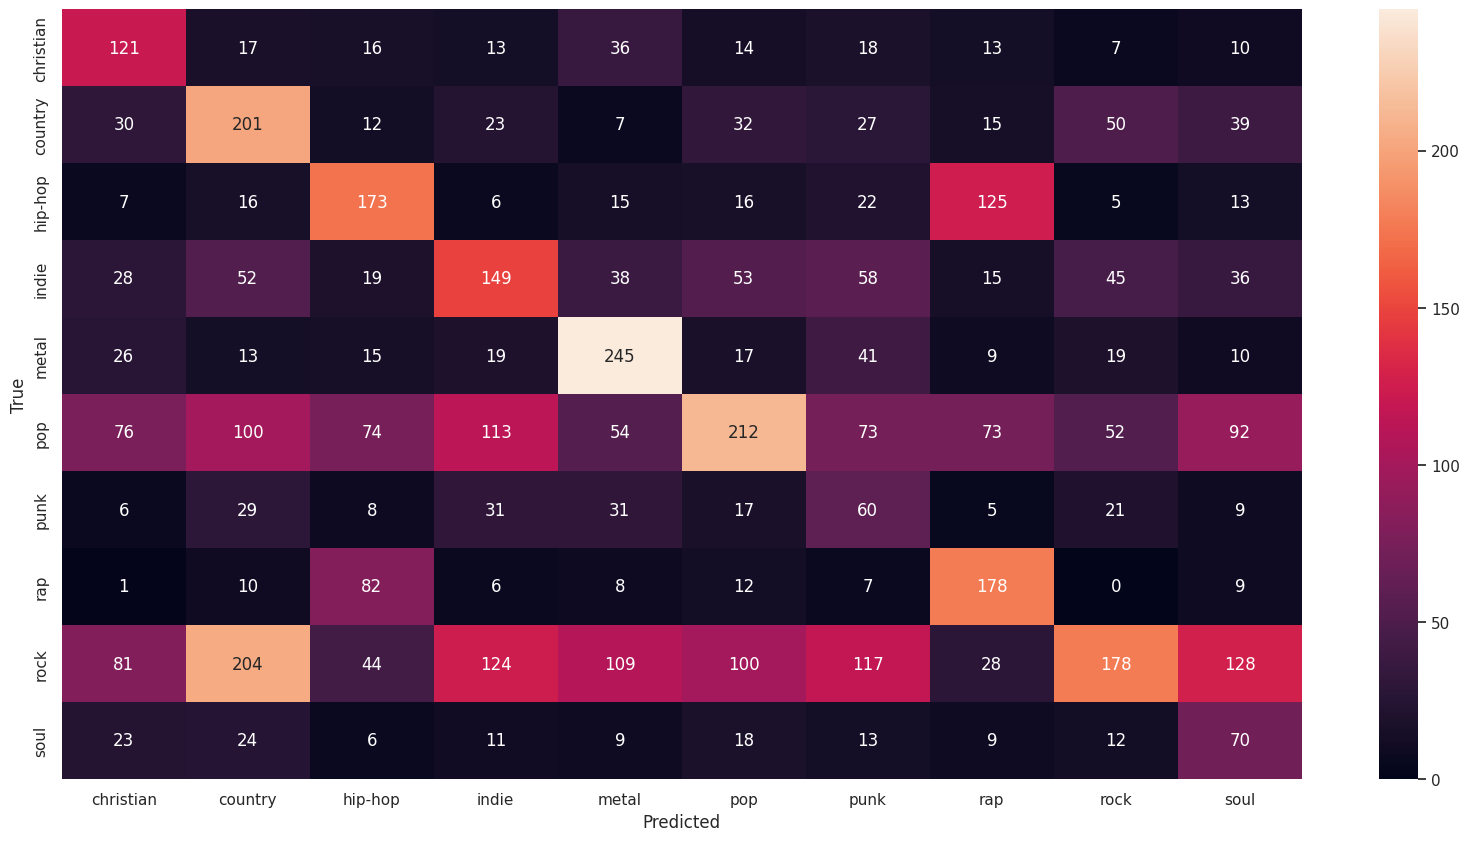

In [7]:
model_name = 'embedding-then-one-layer'
embedding_then_one_layer_model = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, model_type="embedding_then_one_layer")
embedding_then_one_layer_model.to(device)
optimizer = optim.Adam(embedding_then_one_layer_model.parameters(), lr=learning_rate) 
print(model_summary(embedding_then_one_layer_model))
history = train_and_evaluate(embedding_then_one_layer_model, model_name, 25, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1)

# Using lyrics-bert and convolution

Model summary:
---------------------------
Total parameters: 40397342
None
Model embedding-then-conv1d: Epoch: 1 Train Accuracy: 0.0945 Test Accuracy: 0.1602 F1 Score: 0.1053 Train Loss: 0.0054 Test Loss: 0.0048 Train Time/Step: 0.2262 Eval Time/Step: 0.2278
Model embedding-then-conv1d: Epoch: 2 Train Accuracy: 0.1423 Test Accuracy: 0.1751 F1 Score: 0.0888 Train Loss: 0.0045 Test Loss: 0.0046 Train Time/Step: 0.1923 Eval Time/Step: 0.2258
Model embedding-then-conv1d: Epoch: 3 Train Accuracy: 0.1833 Test Accuracy: 0.2608 F1 Score: 0.2266 Train Loss: 0.0042 Test Loss: 0.0043 Train Time/Step: 0.1882 Eval Time/Step: 0.2331
Model embedding-then-conv1d: Epoch: 4 Train Accuracy: 0.2140 Test Accuracy: 0.2427 F1 Score: 0.1966 Train Loss: 0.0040 Test Loss: 0.0040 Train Time/Step: 0.1963 Eval Time/Step: 0.2324
Model embedding-then-conv1d: Epoch: 5 Train Accuracy: 0.2422 Test Accuracy: 0.2419 F1 Score: 0.2075 Train Loss: 0.0037 Test Loss: 0.0039 Train Time/Step: 0.1913 Eval Time/Step: 0.2295
Model

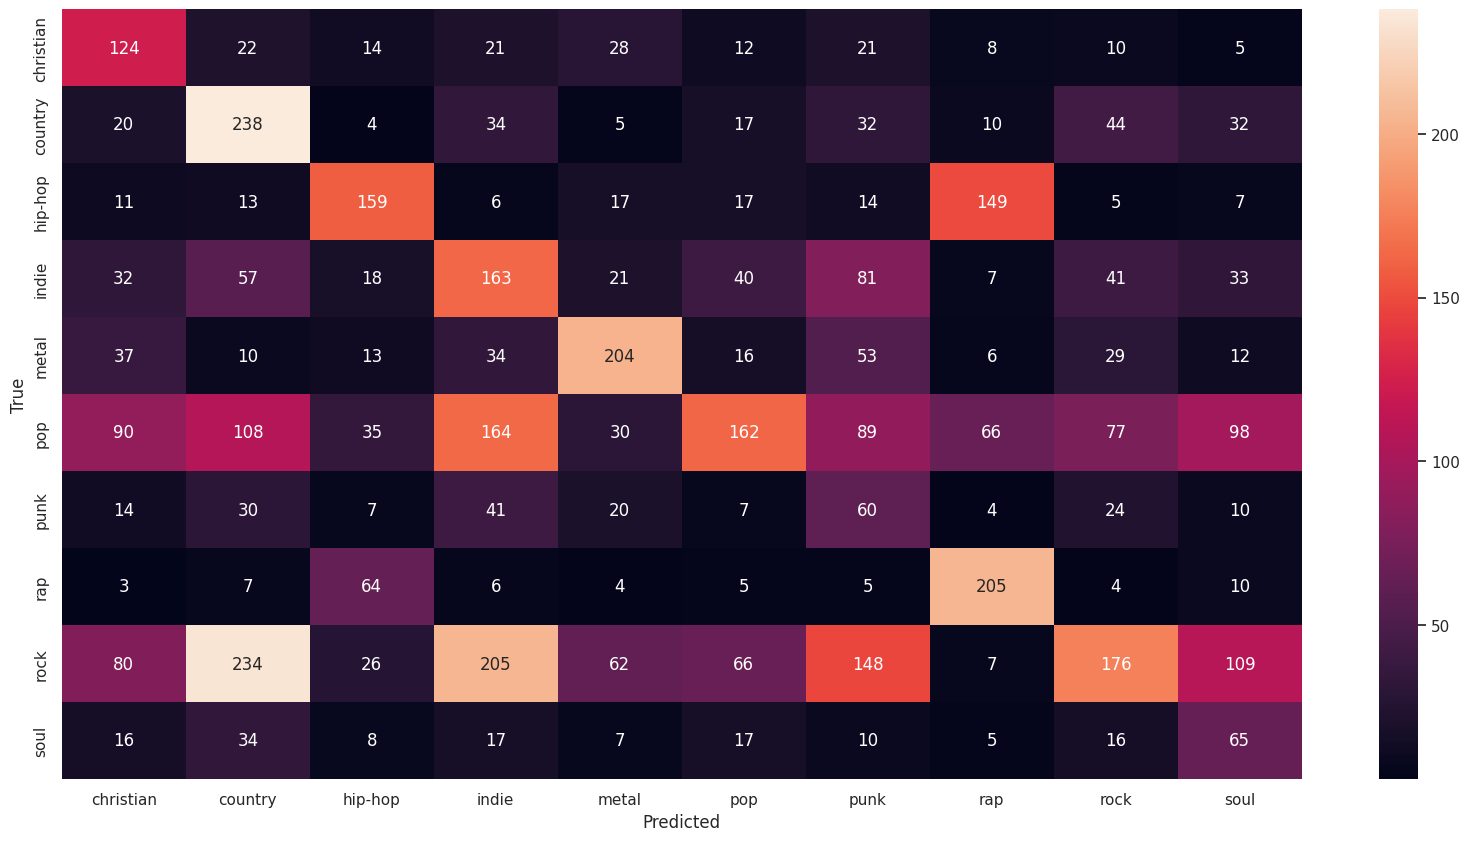

In [8]:
model_name = 'embedding-then-conv1d'
embedding_then_conv1d = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, model_type="embedding-then-conv1d")
embedding_then_conv1d.to(device)
optimizer = optim.Adam(embedding_then_conv1d.parameters(), lr=learning_rate) 
print(model_summary(embedding_then_conv1d))
history = train_and_evaluate(embedding_then_conv1d, model_name, 25, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1)

# Using batch normalization, learning scheduler

Model summary:
---------------------------
Total parameters: 40397342
None
Model embedding-then-conv1d-bn-scheduler: Epoch: 1 Train Accuracy: 0.0910 Test Accuracy: 0.1035 F1 Score: 0.0194 Train Loss: 0.0065 Test Loss: 0.0048 Train Time/Step: 0.1940 Eval Time/Step: 0.2365
Model embedding-then-conv1d-bn-scheduler: Epoch: 2 Train Accuracy: 0.1004 Test Accuracy: 0.1216 F1 Score: 0.0619 Train Loss: 0.0046 Test Loss: 0.0048 Train Time/Step: 0.1976 Eval Time/Step: 0.2371
Model embedding-then-conv1d-bn-scheduler: Epoch: 3 Train Accuracy: 0.1018 Test Accuracy: 0.1682 F1 Score: 0.0763 Train Loss: 0.0046 Test Loss: 0.0048 Train Time/Step: 0.1942 Eval Time/Step: 0.2380
Model embedding-then-conv1d-bn-scheduler: Epoch: 4 Train Accuracy: 0.1416 Test Accuracy: 0.1953 F1 Score: 0.1278 Train Loss: 0.0045 Test Loss: 0.0046 Train Time/Step: 0.1953 Eval Time/Step: 0.2368
Model embedding-then-conv1d-bn-scheduler: Epoch: 5 Train Accuracy: 0.1735 Test Accuracy: 0.2870 F1 Score: 0.2288 Train Loss: 0.0043 Test 

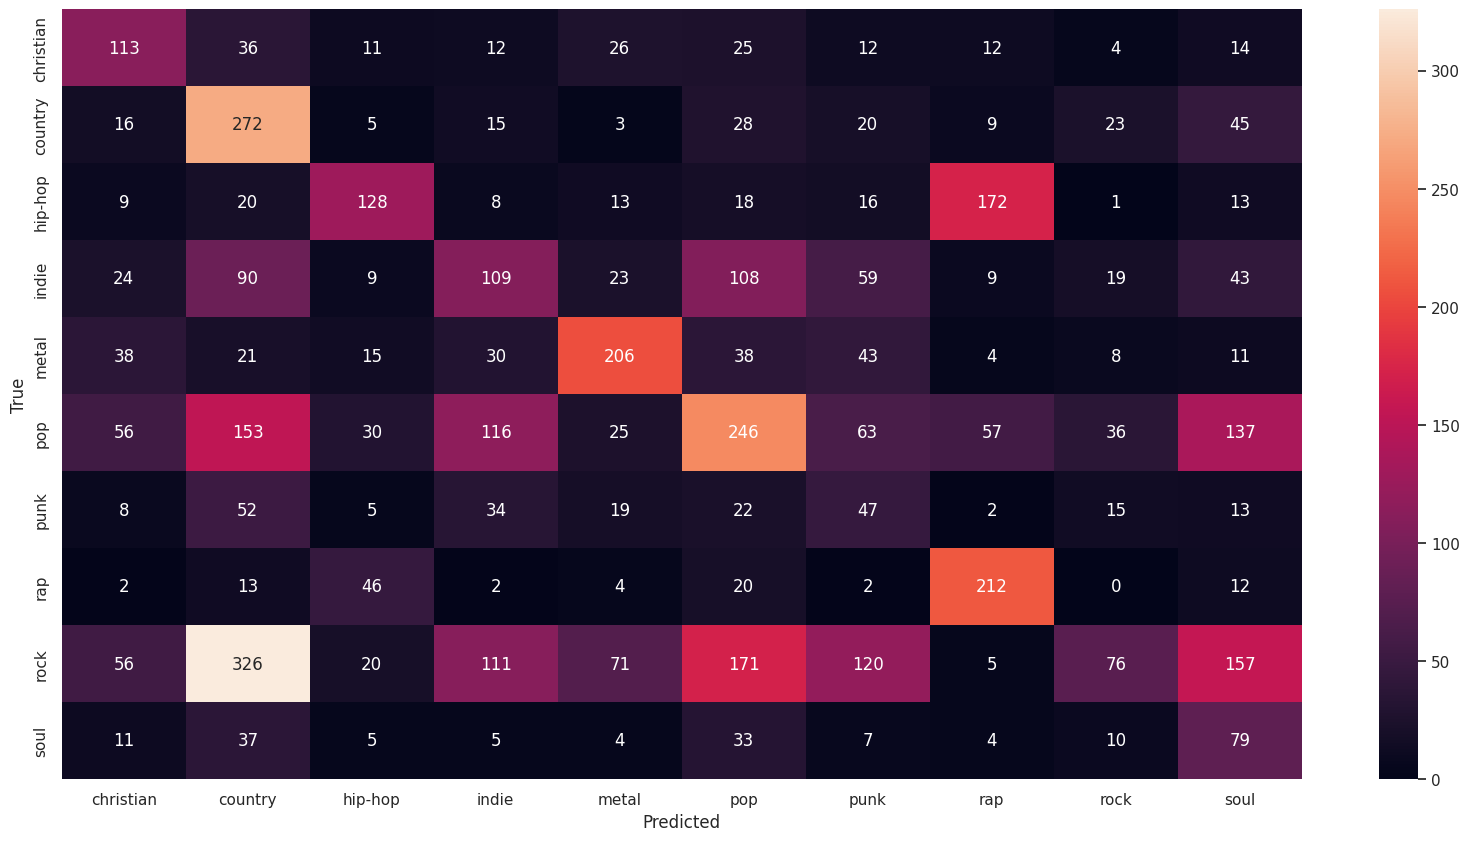

In [9]:
model_name = 'embedding-then-conv1d-bn-scheduler'

embedding_then_conv1d_bn_scheduler = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, model_type="embedding-then-conv1d")
embedding_then_conv1d_bn_scheduler.to(device)
optimizer = optim.Adam(embedding_then_conv1d_bn_scheduler.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(embedding_then_conv1d_bn_scheduler))
history = train_and_evaluate(embedding_then_conv1d_bn_scheduler, model_name, 25, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

# Fully connected layer with batch normalization and learning scheduler

Model summary:
---------------------------
Total parameters: 65550622
None
Model fc-with-batch-normalization: Epoch: 1 Train Accuracy: 0.2411 Test Accuracy: 0.2912 F1 Score: 0.3019 Train Loss: 0.0041 Test Loss: 0.0044 Train Time/Step: 0.1783 Eval Time/Step: 0.1910
Model fc-with-batch-normalization: Epoch: 2 Train Accuracy: 0.2964 Test Accuracy: 0.2876 F1 Score: 0.2759 Train Loss: 0.0039 Test Loss: 0.0042 Train Time/Step: 0.1742 Eval Time/Step: 0.1922
Model fc-with-batch-normalization: Epoch: 3 Train Accuracy: 0.3313 Test Accuracy: 0.2948 F1 Score: 0.2794 Train Loss: 0.0037 Test Loss: 0.0041 Train Time/Step: 0.1744 Eval Time/Step: 0.1932
Model fc-with-batch-normalization: Epoch: 4 Train Accuracy: 0.3801 Test Accuracy: 0.3137 F1 Score: 0.3025 Train Loss: 0.0036 Test Loss: 0.0041 Train Time/Step: 0.1762 Eval Time/Step: 0.1958
Model fc-with-batch-normalization: Epoch: 5 Train Accuracy: 0.4277 Test Accuracy: 0.3342 F1 Score: 0.3250 Train Loss: 0.0036 Test Loss: 0.0041 Train Time/Step: 0.187

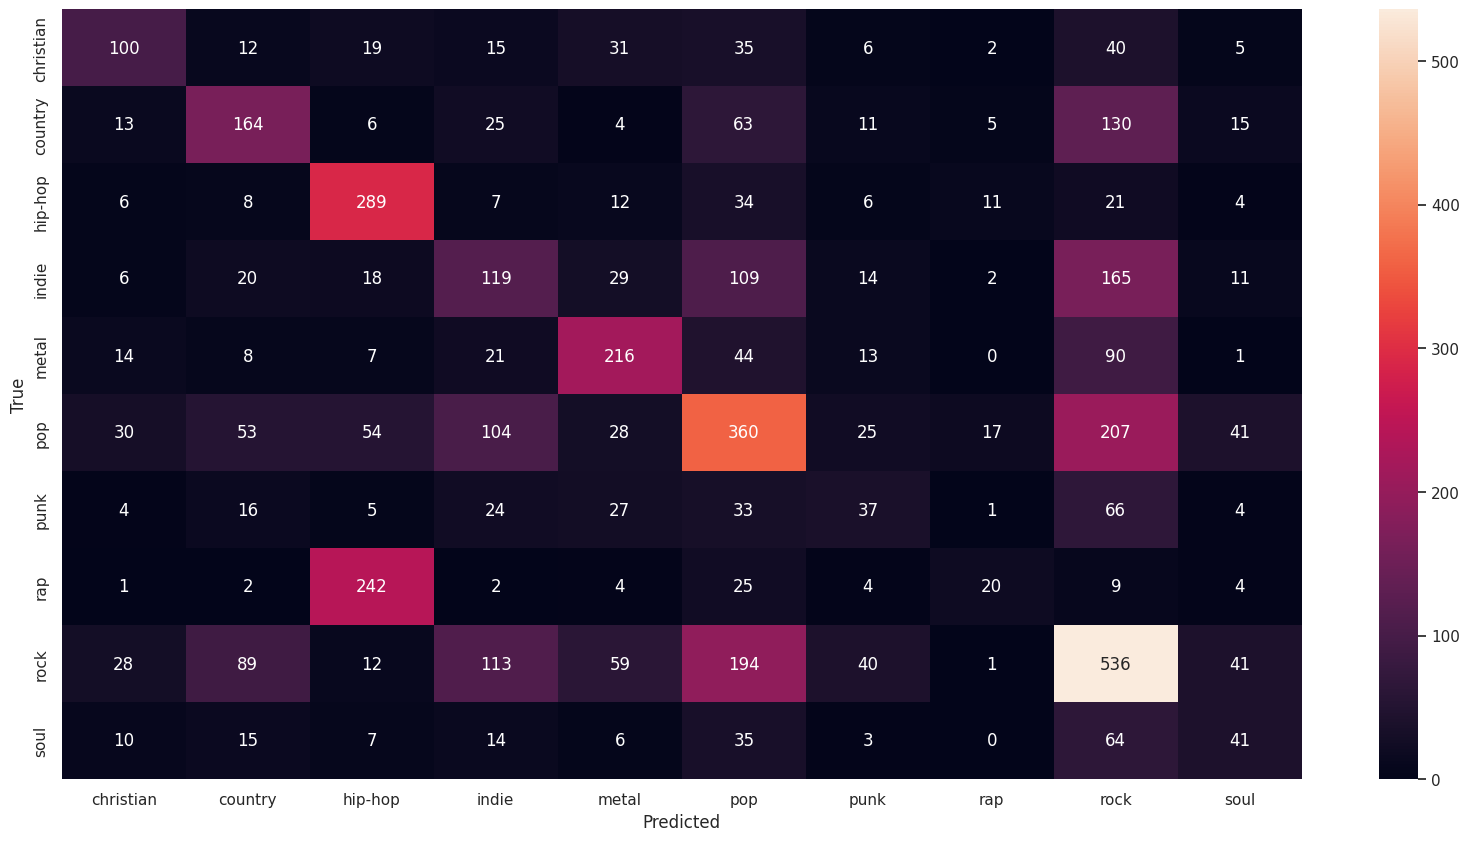

In [10]:
model_name = 'fc-with-batch-normalization'

fc_with_batch_normalization = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, model_type="fc-with-batch-normalization")
fc_with_batch_normalization.to(device)
optimizer = optim.Adam(fc_with_batch_normalization.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization))
history = train_and_evaluate(fc_with_batch_normalization, model_name, 25, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

# Same with distilbert base (a bigger, more generally applicable bert model)

No sentence-transformers model found with name /home/bruno/.cache/torch/sentence_transformers/distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/bruno/.cache/torch/sentence_transformers/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 119792650
None
Model fc-with-batch-normalization-bert-base: Epoch: 1 Train Accuracy: 0.3003 Test Accuracy: 0.3294 F1 Score: 0.3517 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.6889 Eval Time/Step: 1.5465
Model fc-with-batch-normalization-bert-base: Epoch: 2 Train Accuracy: 0.3514 Test Accuracy: 0.3185 F1 Score: 0.2860 Train Loss: 0.0038 Test Loss: 0.0041 Train Time/Step: 0.6529 Eval Time/Step: 1.4743
Model fc-with-batch-normalization-bert-base: Epoch: 3 Train Accuracy: 0.3580 Test Accuracy: 0.3563 F1 Score: 0.3317 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 0.6977 Eval Time/Step: 1.5206
Model fc-with-batch-normalization-bert-base: Epoch: 4 Train Accuracy: 0.3662 Test Accuracy: 0.3659 F1 Score: 0.3375 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 0.6608 Eval Time/Step: 1.4334
Model fc-with-batch-normalization-bert-base: Epoch: 5 Train Accuracy: 0.3841 Test Accuracy: 0.3704 F1 Score: 0.3582 Train Lo

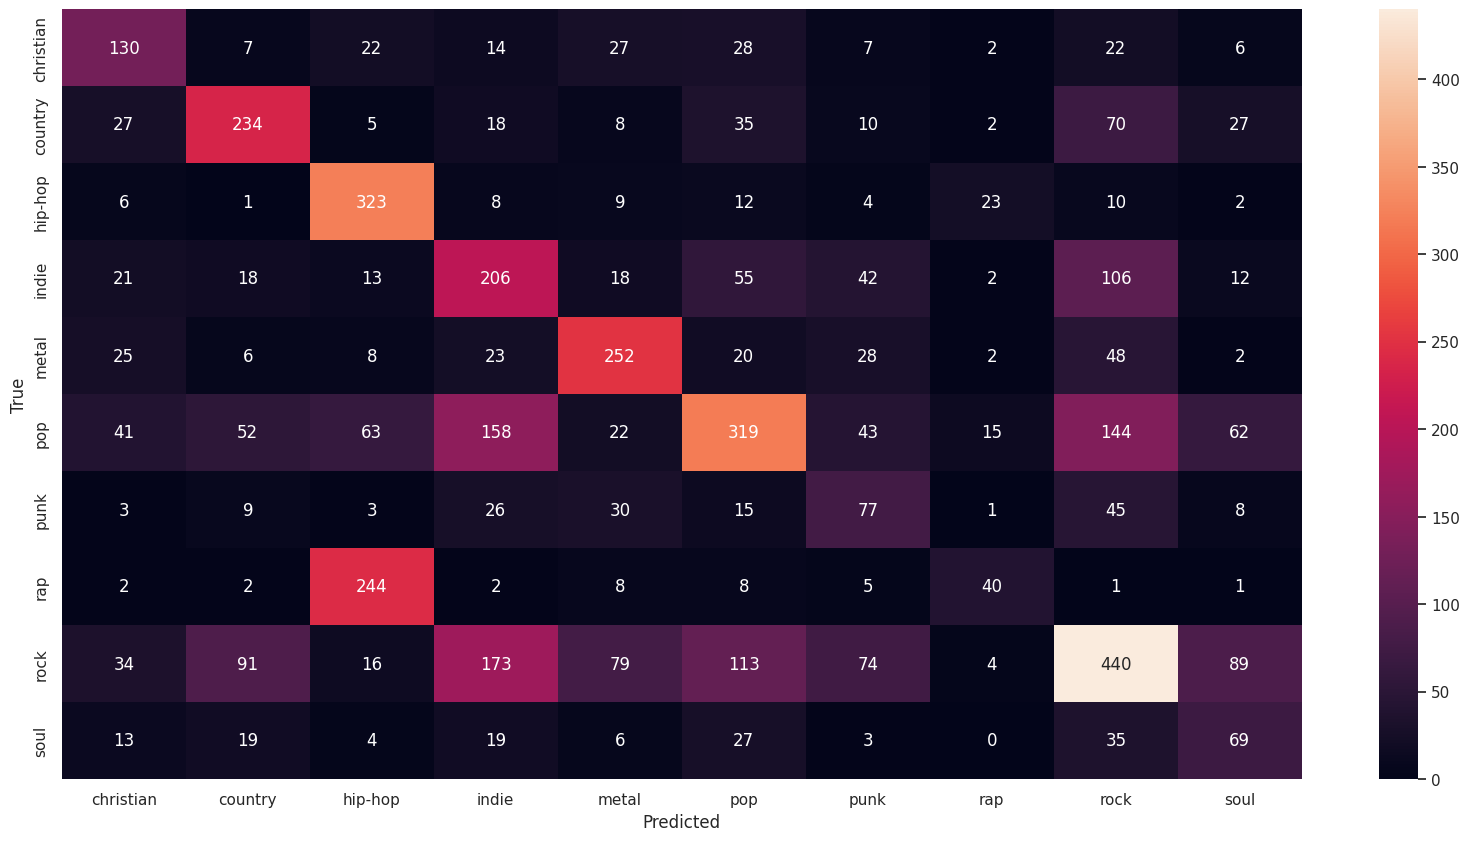

In [12]:
model_name = 'fc-with-batch-normalization-bert-base'

fc_with_batch_normalization_bert_base = LyricsTextClassificationModel(SentenceTransformer("distilbert-base-uncased"), 768, categories, model_type="fc-with-batch-normalization", bert_type="distilbert")
fc_with_batch_normalization_bert_base.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_bert_base.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_bert_base))
history = train_and_evaluate(fc_with_batch_normalization_bert_base, model_name, 25, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

No sentence-transformers model found with name /home/bruno/.cache/torch/sentence_transformers/distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/bruno/.cache/torch/sentence_transformers/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 116444426
None
Model embedding-then-conv1d-bn-scheduler-distilbert-base: Epoch: 1 Train Accuracy: 0.1191 Test Accuracy: 0.1929 F1 Score: 0.1529 Train Loss: 0.0145 Test Loss: 0.0047 Train Time/Step: 0.6665 Eval Time/Step: 1.4276
Model embedding-then-conv1d-bn-scheduler-distilbert-base: Epoch: 2 Train Accuracy: 0.1439 Test Accuracy: 0.1843 F1 Score: 0.1341 Train Loss: 0.0044 Test Loss: 0.0045 Train Time/Step: 0.6703 Eval Time/Step: 1.4948
Model embedding-then-conv1d-bn-scheduler-distilbert-base: Epoch: 3 Train Accuracy: 0.1862 Test Accuracy: 0.2001 F1 Score: 0.1335 Train Loss: 0.0042 Test Loss: 0.0042 Train Time/Step: 0.6878 Eval Time/Step: 1.4275
Model embedding-then-conv1d-bn-scheduler-distilbert-base: Epoch: 4 Train Accuracy: 0.2132 Test Accuracy: 0.2895 F1 Score: 0.2548 Train Loss: 0.0039 Test Loss: 0.0039 Train Time/Step: 0.6822 Eval Time/Step: 1.4447
Model embedding-then-conv1d-bn-scheduler-distilbert-base: Epoch: 5 Train

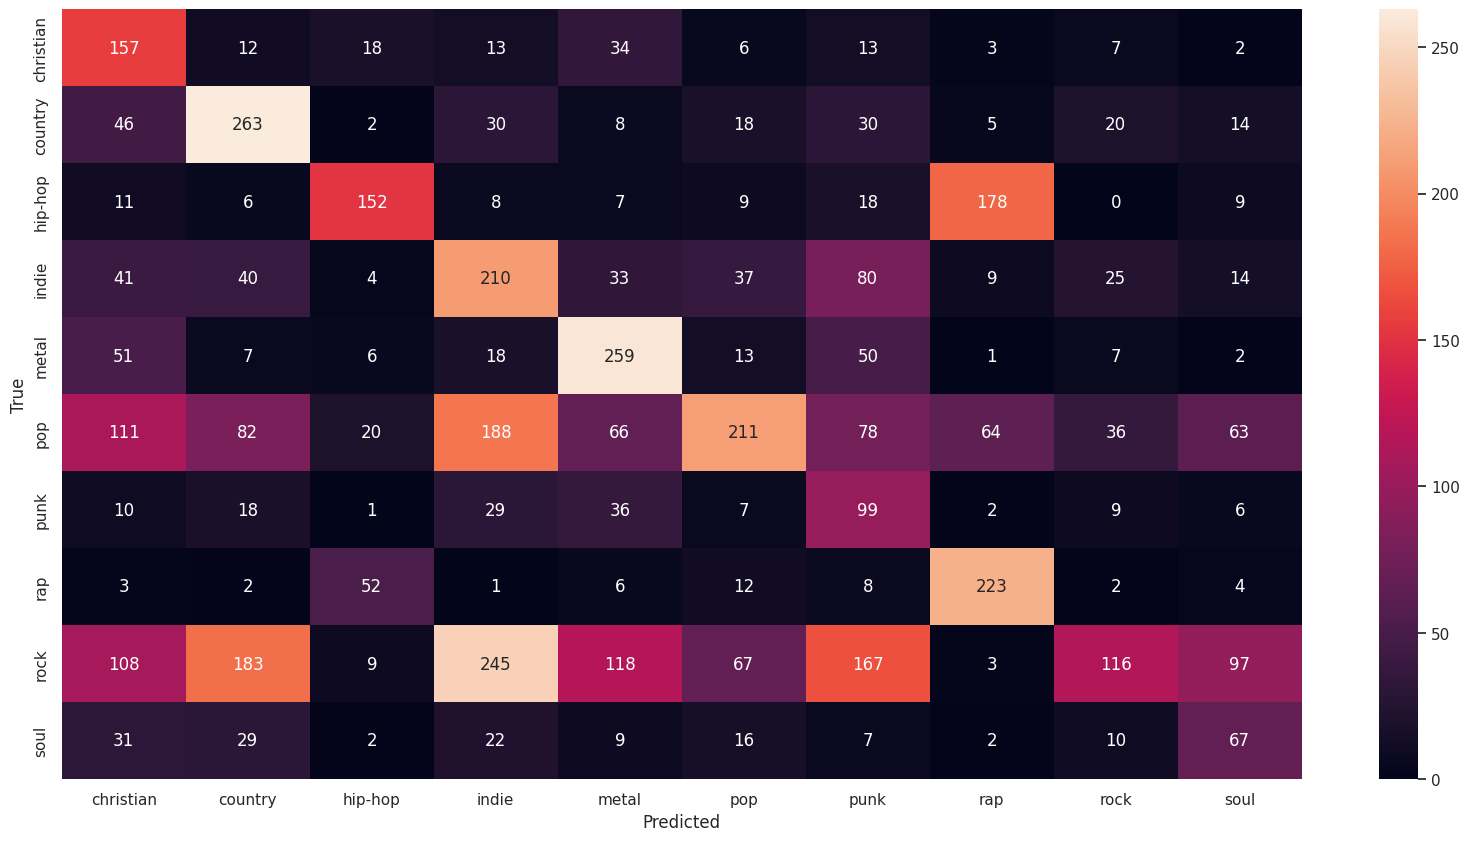

In [13]:
model_name = 'embedding-then-conv1d-bn-scheduler-distilbert-base'

embedding_then_conv1d_bn_scheduler_distilbert_base = LyricsTextClassificationModel(SentenceTransformer("distilbert-base-uncased"), 768, categories, model_type="embedding-then-conv1d", bert_type="distilbert")
embedding_then_conv1d_bn_scheduler_distilbert_base.to(device)
optimizer = optim.Adam(embedding_then_conv1d_bn_scheduler_distilbert_base.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(embedding_then_conv1d_bn_scheduler_distilbert_base))
history = train_and_evaluate(embedding_then_conv1d_bn_scheduler_distilbert_base, model_name, 25, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

# Using a text data augmentor for augmenting the lyrics

No sentence-transformers model found with name /home/bruno/.cache/torch/sentence_transformers/distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/bruno/.cache/torch/sentence_transformers/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 116444426
None
Model fc-with-batch-normalization-distilbert-base-nlpaug: Epoch: 1 Train Accuracy: 0.1069 Test Accuracy: 0.1262 F1 Score: 0.0538 Train Loss: 0.0168 Test Loss: 0.0048 Train Time/Step: 0.6490 Eval Time/Step: 1.4234
Model fc-with-batch-normalization-distilbert-base-nlpaug: Epoch: 2 Train Accuracy: 0.0929 Test Accuracy: 0.1102 F1 Score: 0.0399 Train Loss: 0.0046 Test Loss: 0.0048 Train Time/Step: 0.6607 Eval Time/Step: 1.4287
Model fc-with-batch-normalization-distilbert-base-nlpaug: Epoch: 3 Train Accuracy: 0.1080 Test Accuracy: 0.1843 F1 Score: 0.1279 Train Loss: 0.0045 Test Loss: 0.0047 Train Time/Step: 0.6614 Eval Time/Step: 1.4569
Model fc-with-batch-normalization-distilbert-base-nlpaug: Epoch: 4 Train Accuracy: 0.1144 Test Accuracy: 0.1350 F1 Score: 0.0904 Train Loss: 0.0044 Test Loss: 0.0045 Train Time/Step: 0.6619 Eval Time/Step: 1.4006
Model fc-with-batch-normalization-distilbert-base-nlpaug: Epoch: 5 Train

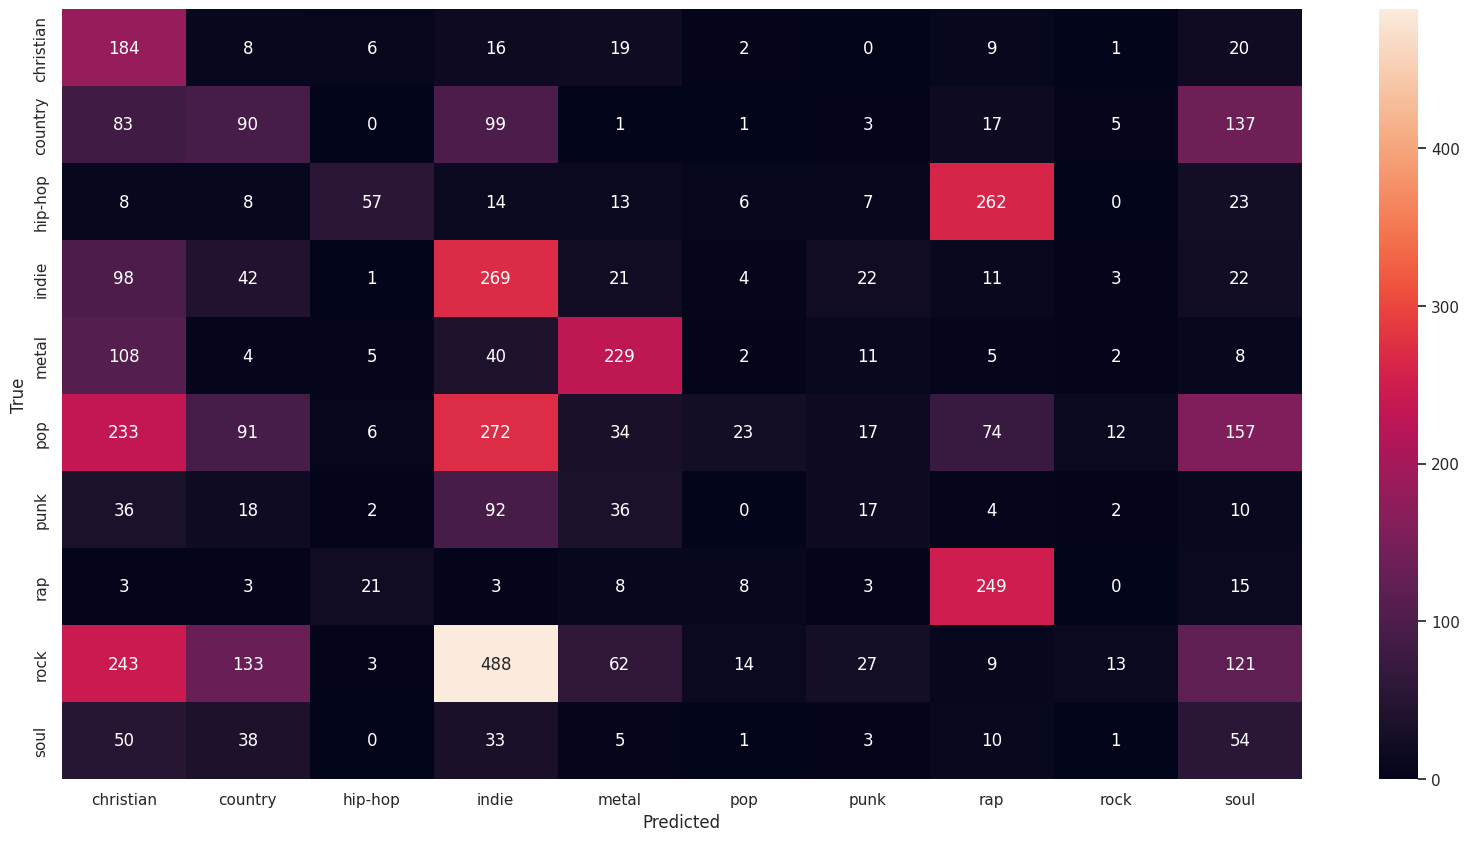

In [14]:
model_name = 'fc-with-batch-normalization-distilbert-base-nlpaug'
train_dataset_nlpaug = LyricsDataset(train_features, train_targets, augment=True)
train_dataloader_nlpaug = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

fc_with_batch_normalization_bert_base_nlpaug = LyricsTextClassificationModel(SentenceTransformer("distilbert-base-uncased"), 768, categories, model_type="embedding-then-conv1d", bert_type="distilbert")
fc_with_batch_normalization_bert_base_nlpaug.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_bert_base_nlpaug.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_bert_base_nlpaug))
history = train_and_evaluate(fc_with_batch_normalization_bert_base_nlpaug, model_name, 25, criterion, optimizer, train_dataloader_nlpaug, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

No sentence-transformers model found with name /home/bruno/.cache/torch/sentence_transformers/prajjwal1_bert-tiny. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/bruno/.cache/torch/sentence_transformers/prajjwal1_bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a Be

Model summary:
---------------------------
Total parameters: 4387210
None
Model embedding-then-one-layer_tiny_bert: Epoch: 1 Train Accuracy: 0.1548 Test Accuracy: 0.2341 F1 Score: 0.1918 Train Loss: 0.0045 Test Loss: 0.0046 Train Time/Step: 0.1937 Eval Time/Step: 0.1715
Model embedding-then-one-layer_tiny_bert: Epoch: 2 Train Accuracy: 0.2430 Test Accuracy: 0.2576 F1 Score: 0.2398 Train Loss: 0.0042 Test Loss: 0.0043 Train Time/Step: 0.1914 Eval Time/Step: 0.1663
Model embedding-then-one-layer_tiny_bert: Epoch: 3 Train Accuracy: 0.2697 Test Accuracy: 0.2723 F1 Score: 0.2595 Train Loss: 0.0040 Test Loss: 0.0042 Train Time/Step: 0.1831 Eval Time/Step: 0.1661
Model embedding-then-one-layer_tiny_bert: Epoch: 4 Train Accuracy: 0.2834 Test Accuracy: 0.3042 F1 Score: 0.2858 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.1788 Eval Time/Step: 0.1673
Model embedding-then-one-layer_tiny_bert: Epoch: 5 Train Accuracy: 0.3025 Test Accuracy: 0.3179 F1 Score: 0.3045 Train Loss: 0.0038 Test L

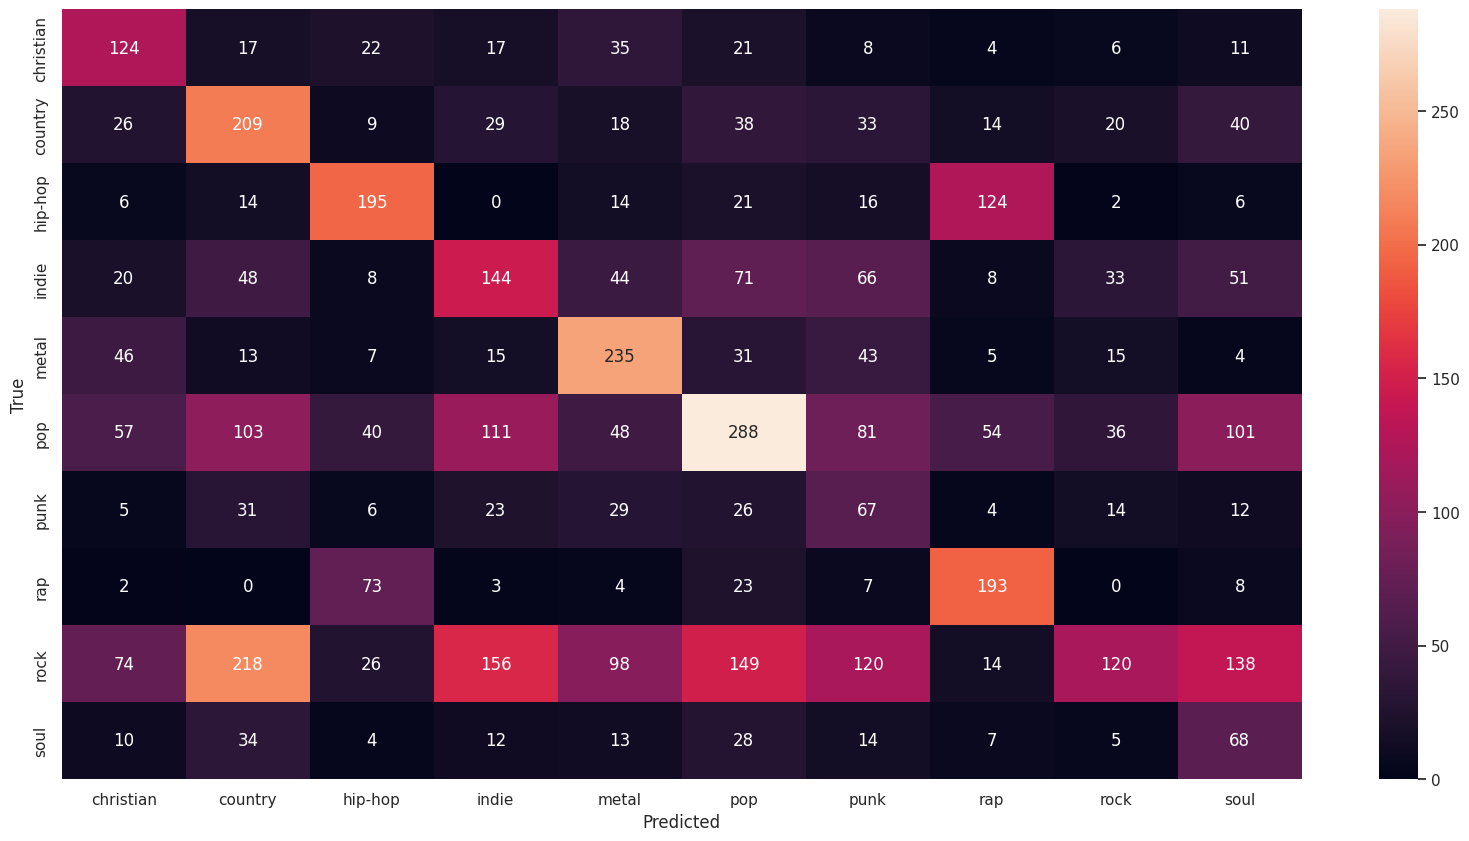

In [15]:
model_name = 'embedding-then-one-layer_tiny_bert'
embedding_then_one_layer_model_tiny_bert = LyricsTextClassificationModel(SentenceTransformer("prajjwal1/bert-tiny"), 128, categories, model_type="embedding_then_one_layer")
embedding_then_one_layer_model_tiny_bert.to(device)
optimizer = optim.Adam(embedding_then_one_layer_model_tiny_bert.parameters(), lr=learning_rate) 
print(model_summary(embedding_then_one_layer_model_tiny_bert))
history = train_and_evaluate(embedding_then_one_layer_model_tiny_bert, model_name, 25, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1)

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializin

Model summary:
---------------------------
Total parameters: 45691530
None
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 1 Train Accuracy: 0.2431 Test Accuracy: 0.2992 F1 Score: 0.2873 Train Loss: 0.0040 Test Loss: 0.0042 Train Time/Step: 0.2903 Eval Time/Step: 0.2535
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 2 Train Accuracy: 0.2851 Test Accuracy: 0.2803 F1 Score: 0.2668 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.2846 Eval Time/Step: 0.2501
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 3 Train Accuracy: 0.2906 Test Accuracy: 0.2769 F1 Score: 0.2585 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.2922 Eval Time/Step: 0.2527
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 4 Train Accuracy: 0.2980 Test Accuracy: 0.2853 F1 Score: 0.2690 Train Loss: 0.0038 Test Loss: 0.0041 Train Time/Step: 0.2887 Eval Time/Step: 0.2510
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 5 Train Accuracy: 0.3084 Test Accuracy

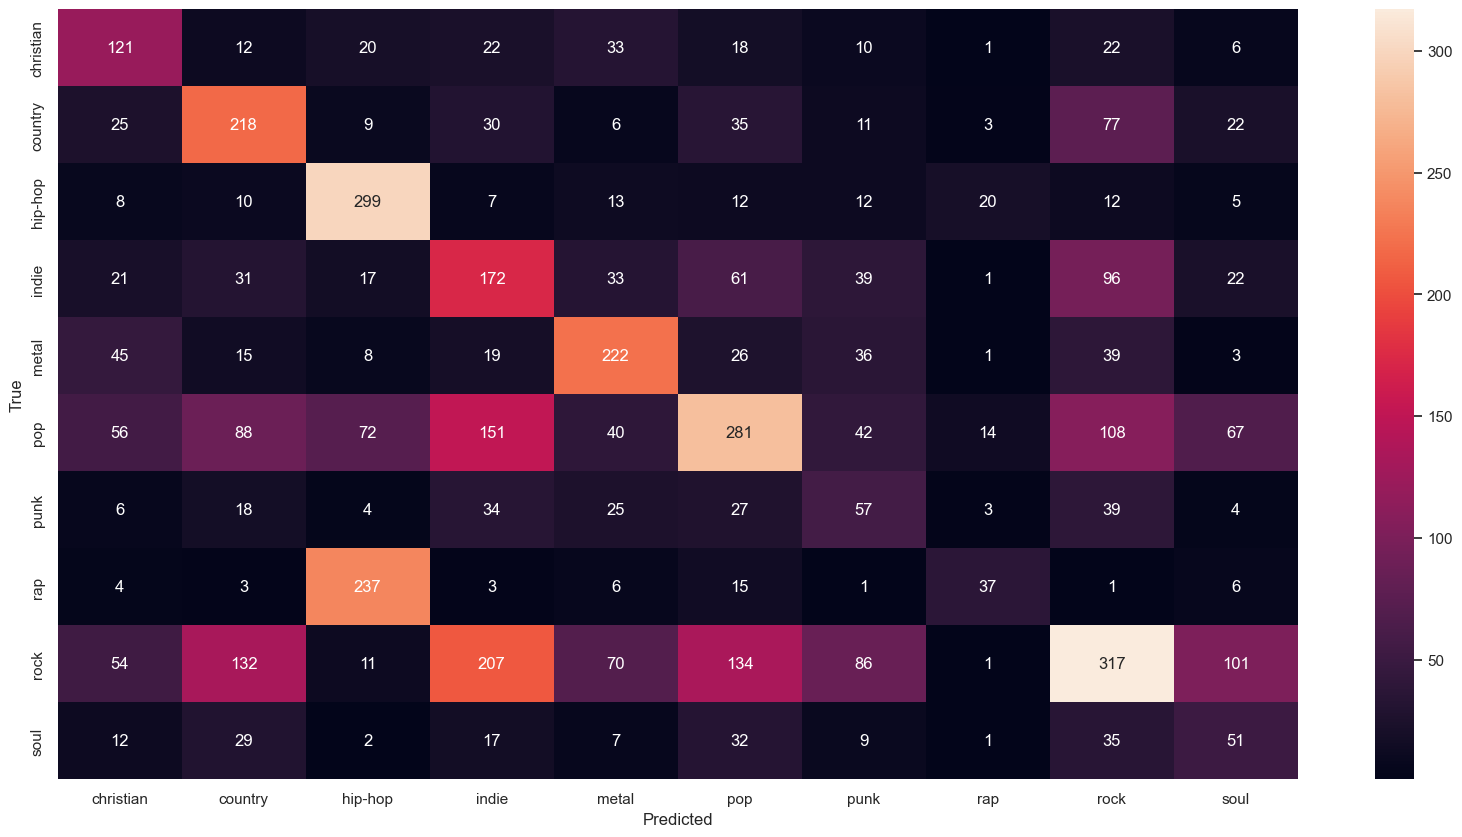

In [ ]:
model_name = 'fc-with-batch-normalization-bert-tiny-nlpaug'

train_dataset_nlpaug = LyricsDataset(train_features, train_targets, augment=True)
train_dataloader_nlpaug = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

fc_with_batch_normalization_bert_tiny_nlpaug = LyricsTextClassificationModel(SentenceTransformer("prajjwal1/bert-tiny"), 128, categories, model_type="fc-with-batch-normalization")
fc_with_batch_normalization_bert_tiny_nlpaug.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_bert_tiny_nlpaug.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_bert_tiny_nlpaug))
history = train_and_evaluate(fc_with_batch_normalization_bert_tiny_nlpaug, model_name, 25, criterion, optimizer, train_dataloader_nlpaug, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializin

Model summary:
---------------------------
Total parameters: 45691530
None
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 1 Train Accuracy: 0.2531 Test Accuracy: 0.3153 F1 Score: 0.3080 Train Loss: 0.0040 Test Loss: 0.0042 Train Time/Step: 0.3208 Eval Time/Step: 0.2860
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 2 Train Accuracy: 0.2853 Test Accuracy: 0.2897 F1 Score: 0.2641 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.3121 Eval Time/Step: 0.2679
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 3 Train Accuracy: 0.3011 Test Accuracy: 0.3153 F1 Score: 0.2961 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.3019 Eval Time/Step: 0.2664
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 4 Train Accuracy: 0.3050 Test Accuracy: 0.3158 F1 Score: 0.2985 Train Loss: 0.0038 Test Loss: 0.0041 Train Time/Step: 0.2997 Eval Time/Step: 0.2610
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 5 Train Accuracy: 0.3206 Test Accuracy: 0.3265 F

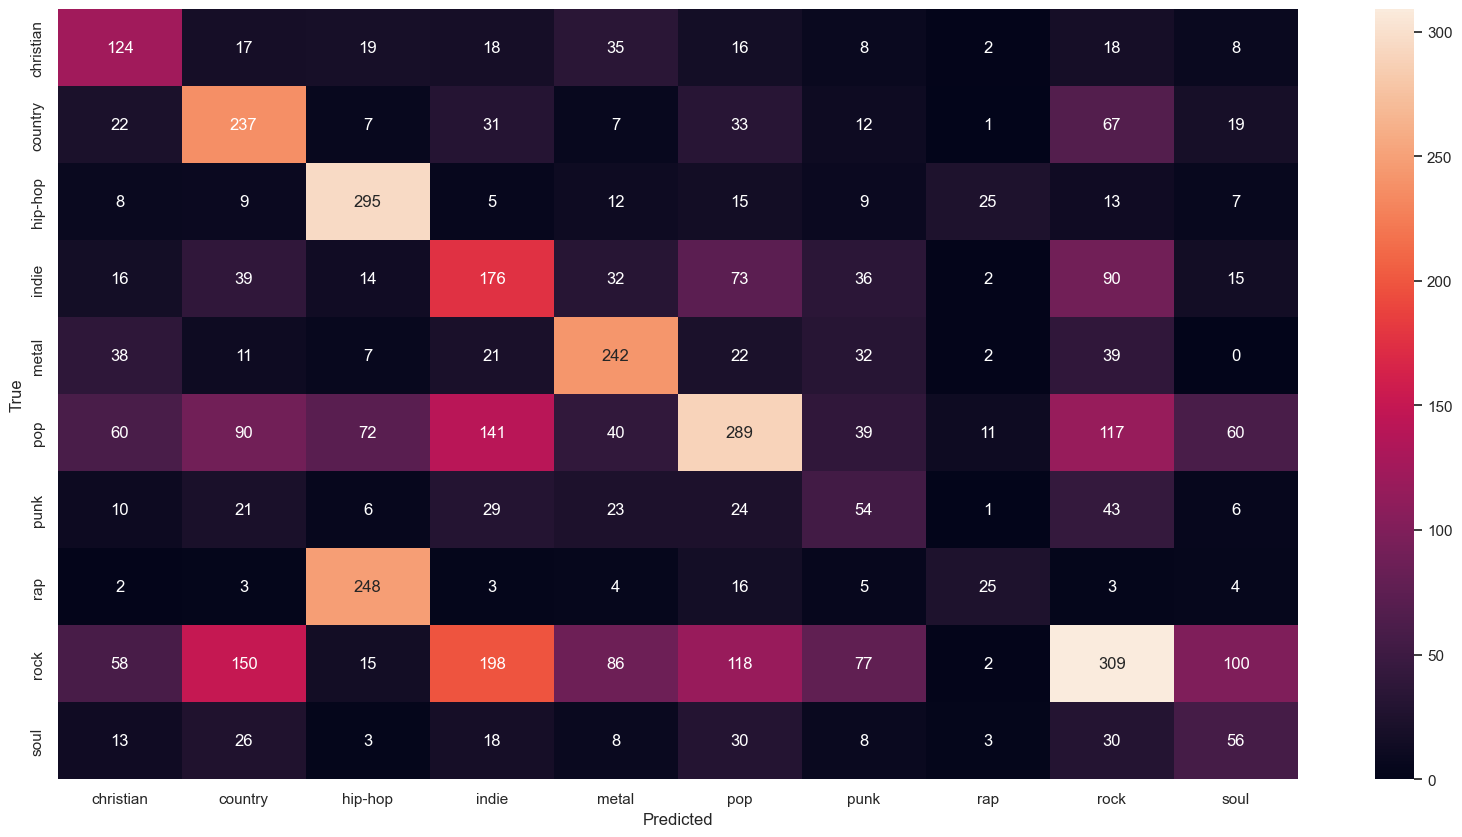

In [ ]:
model_name = 'fc-with-batch-normalization-st5-xxl-nlpaug'
train_dataset_nlpaug = LyricsDataset(train_features, train_targets, augment=True)
train_dataloader_nlpaug = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

fc_with_batch_normalization_st5_xxl_nlpaug = LyricsTextClassificationModel(SentenceTransformer("prajjwal1/bert-tiny"), 128, categories, model_type="fc-with-batch-normalization")
fc_with_batch_normalization_st5_xxl_nlpaug.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_st5_xxl_nlpaug.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_st5_xxl_nlpaug))
history = train_and_evaluate(fc_with_batch_normalization_st5_xxl_nlpaug, model_name, 25, criterion, optimizer, train_dataloader_nlpaug, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

Model summary:
---------------------------
Total parameters: 20986644


c:\Users\bruno\.conda\envs\my_env\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 19052, number of used features: 300
[LightGBM] [Info] Start training from score -2.943180
[LightGBM] [Info] Start training from score -2.393287
[LightGBM] [Info] Start training from score -2.443371
[LightGBM] [Info] Start training from score -2.278830
[LightGBM] [Info] Start training from score -2.524522
[LightGBM] [Info] Start training from score -1.631837
[LightGBM] [Info] Start training from score -3.092198
[LightGBM] [Info] Start training from score -2.656744
[LightGBM] [Info] Start training from score -1.438439
[LightGBM] [Info] Start training from score -3.266001
[1]	valid_0's multi_logloss: 2.10195
Training until validation scores don't improve for 25 rounds
[2]	valid_0's multi_logloss: 2.06762
[3]	valid_0's multi_logloss: 2.

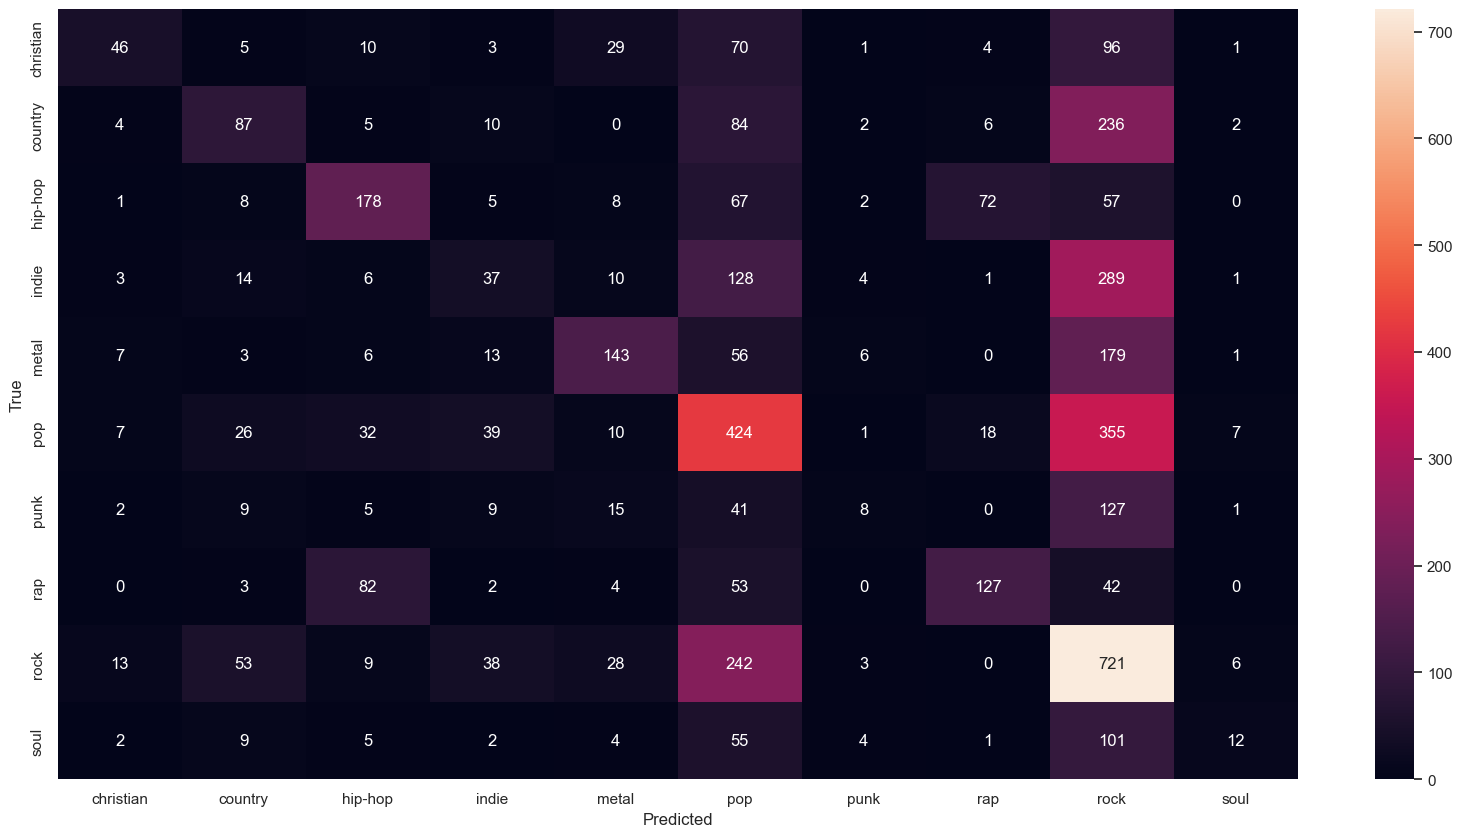

In [21]:
import lightgbm as lgb

class BertFeatureExtractor(torch.nn.Module):
    def __init__(self, embedding_model):
        super(BertFeatureExtractor, self).__init__()
        self.embedding_model = embedding_model
    
    def forward(self, x):
        x = self.embedding_model.encode(x, convert_to_tensor=True)
        return x

# Initialize BERT feature extractor
bert_extractor = BertFeatureExtractor(SentenceTransformer('../models/lyrics-bert/'))
bert_extractor.to(device)
model_summary(bert_extractor)

train_features_lgb = []
train_targets_lgb = []
for inputs, labels in train_dataloader:
    outputs = bert_extractor(inputs)
    train_features_lgb.append(outputs.detach().cpu().numpy())
    train_targets_lgb.append(labels.detach().cpu().numpy())
train_features_lgb = np.vstack(train_features_lgb)
train_targets_lgb = np.array([item for sublist in train_targets_lgb for item in sublist])

# Generate features for training data
test_features_lgb = []
test_targets_lgb = []
for inputs, labels in test_dataloader:
    outputs = bert_extractor(inputs)
    test_features_lgb.append(outputs.detach().cpu().numpy())
    test_targets_lgb.append(labels.detach().cpu().numpy())
test_features_lgb = np.vstack(test_features_lgb)
test_targets_lgb = np.array([item for sublist in test_targets_lgb for item in sublist])

# Train LightGBM model on generated features
train_data_lgb = lgb.Dataset(train_features_lgb, label=train_targets_lgb)
test_data_lgb = lgb.Dataset(test_features_lgb, label=test_targets_lgb)
params = {'objective': 'multiclass', 'num_class': len(categories), 'metric': 'multi_logloss'}
model = lgb.train(params, train_data_lgb, num_boost_round=1000, valid_sets=[test_data_lgb], early_stopping_rounds=25)

# Evaluate LightGBM model on test data
y_pred = model.predict(test_features_lgb)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_targets_lgb, y_pred)
report = classification_report(test_targets_lgb, y_pred, target_names=categories)
print(report)
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()